# IV Curve Seminar

In [1]:
from numpy import arange, exp, argmax, sqrt, diag
from math import factorial
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from scipy.constants import Boltzmann, elementary_charge
import pandas as pd

pd.options.mode.chained_assignment = None  # default='warn'

class PlotClass:
    def __init__(me):
        me.plots = {}

    def add_series(me, name, x, y, mark='-', color='blue'):
        me.plots[name] = [x, y, mark, color]

    def plot(me, xname=None, yname=None, pname=None):
        for name in me.plots:
            xymc = me.plots[name]
            plt.plot(xymc[0], xymc[1], xymc[2], color=xymc[3], label=name)

        if xname: plt.xlabel(xname)
        if yname: plt.ylabel(yname)
        if pname: plt.title(pname)

        plt.legend()
        plt.show()

        me.plots = {}

p = PlotClass()

The general idea here is to:

1. Measure points on the I-V curve by changing $R$
   
2. Estimate $I_L$ and $I_S$ (fit) for this equation and those I-V measurements: <br> $ \hat I (V) = I_L - I_S \ e^{ ( \frac{qV}{nkT} ) } $

3. With $\hat P(V) = V • \hat I(V)$ find the maximum power point

# Measurements

We put a 800 W halogen lamp on four solar cells, two in parallel and two in series.

Each cell was about 6 V and 2.5 W. Length to the cells was L. Angle, as normal as possible.

The 2x2 cell array output had a resistive load $R$ of different values, made by a discrete resistor (22R) or series-parallel combinations. 

$R$ is the rated, not measured, resistence so we should consider the +/- 5% error.

In [2]:
d = pd.read_csv('iv_measurements.csv')
d

,L [cm],irrad [W/m^2],V [V],R [ohm],R error +,R error -
0,60,920,11.8,1000000,1050000.00,950000.00
1,60,920,10.6,34,38.85,35.15
2,60,920,10.5,25,26.25,23.75
3,60,920,10.1,22,23.10,20.90
4,60,920,5.9,12,12.60,11.40
5,60,920,3.1,6,6.30,5.70
6,60,920,2.1,4,4.20,3.80
7,60,920,1.6,3,3.15,2.85


Remove units and the first two columns. 

Also check  `.info()` just in case we have NaNs or a data type problem.

In [3]:
d.columns = ['L', 'irrad', 'V', 'R', 'R+', 'R-']
d = d[['V', 'R', 'R+', 'R-']]
d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   V       8 non-null      float64
 1   R       8 non-null      int64  
 2   R+      8 non-null      float64
 3   R-      8 non-null      float64
dtypes: float64(3), int64(1)
memory usage: 384.0 bytes


Calculate current and power.

$ V = I\ R $ ➡️ $ I = V/R $ <br>
$ P = I\ V $

These could be called indirect measurements, with a simple measurement model (ohm's law):

In [4]:
d['I'] = d['V'] / d['R']
d['P'] = d['V'] * d['I']
d

,V,R,R+,R-,I,P
0,11.8,1000000,1050000.00,950000.00,0.000012,0.000139
1,10.6,34,38.85,35.15,0.311765,3.304706
2,10.5,25,26.25,23.75,0.420000,4.410000
3,10.1,22,23.10,20.90,0.459091,4.636818
4,5.9,12,12.60,11.40,0.491667,2.900833
5,3.1,6,6.30,5.70,0.516667,1.601667
6,2.1,4,4.20,3.80,0.525000,1.102500
7,1.6,3,3.15,2.85,0.533333,0.853333


However, the error of $R$ (+/- 5%) means we also have errors in the indirect measurements of $I$ and $P$:

In [5]:
d['I+'] = d['V'] / d['R-']
d['I-'] = d['V'] / d['R+']
d['P+'] = d['V'] * d['I+']
d['P-'] = d['V'] * d['I-']

We wouldn't have that +/- 5% if we measured $R$. This is mostly a teaching exercise. 

In the real world every instrument has an error (e.g. $V$ +/- 0.5%) and at least these should be considered:
- Accuracy
- Resolution
- Range 

## Plot

Current vs voltage

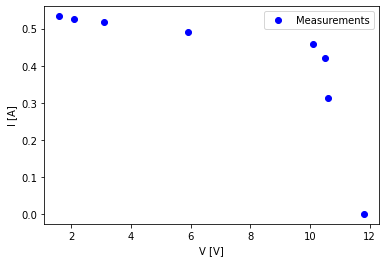

In [6]:
p.add_series('Measurements', d.V, d.I, 'o', 'blue')
p.plot(xname='V [V]', yname='I [A]')

Power vs voltage

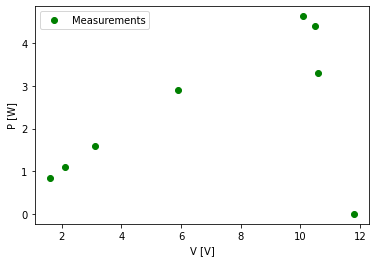

In [7]:
p.add_series('Measurements', d.V, d.P, 'o', 'green')
p.plot(xname='V [V]', yname='P [W]')

Save these simply as $\bf V$ and $\bf I$ for later (both vectors).

In [8]:
V = d['V'].values 
I = d['I'].values 

# Curve fit

## IV equation

There are many mathematical models (equations) to estimate the solar cell current from other inputs like irradiance or voltage. 

A simplified two paramteter model (equation) from this [PV education article](https://www.pveducation.org/pvcdrom/solar-cell-operation/iv-curve#footnote1_zlgyr9m):

$ \hat I (V) = I_L - I_S \ ( e^{ ( \frac{qV}{nkT} ) } - 1) \approx I_L - I_S \ ( e^{ ( \frac{qV}{nkT} ) }) $ _for V>>0.001 V_

_Note the hat_ ($\ \hat{}\ $) _symbol means estimated current, not measured._

We know we'll need some constants.



In [9]:
n = 1.0					# ideality factor
k = Boltzmann 			# joules per kelvin
q = elementary_charge 	# couloumbs
T = 300.0 				# kelvin, about 27 C

Since these are all just numbers, lets simplify things:

$ z = \frac{q}{n k T} $

In [10]:
z = q/(n*k*T)

$ \hat I (V) = I_L - I_S \ e^{ ( \frac{qV}{nkT} ) }  = I_L - I_S \ e^{ zV }  $

In [11]:
def I_hat_eq(v, i_l, i_s):
	return i_l - i_s * ( exp(z*v) )

_Note that `exp(x)` is $e^x$._

The above equation _would_ work fine.

But, to estimate $I_L$ and $I_S$, the function `curve_fit()` uses the non-linear least squares algorithm, and is unable to calculate the covariance matrix when $e^x$ is involved. 

## IV equation with taylor expansion

A taylor expansion of $e^x$ solves this problem:

$e^x = 1 + \frac{x}{1!} + \frac{x^2}{2!} + \frac{x^3}{3!} ...$

Our new equation is:

$ \hat I_t(V) = I_L - I_S \ \biggr( 1 + \frac{zV}{1} + \frac{(zV)^2}{2!} + \frac{(zV)^3}{3!} + ... \biggr) $

Or more compact:

$ \hat I_t(V) = I_L - I_S \ \biggr( 1 + \sum_{i=1}^{\infty} { \frac{(zV)^i}{i!} } \biggr) $ where rather than $\infty$ we will stop at 10.

In [12]:
def I_hat_eq(v, i_l, i_s):
	e_taylor = 1
	for i in range(1,11): 								
		e_taylor += (z*v)**i / factorial(i)
	return i_l - i_s * e_taylor	

_Note some python syntax used ⬆️:_ 
- `x**2` is $x^2$ 
- `x+=1` is $x=x+1$
- `for x in range(1,4)` is _do the loop for_ $x = 1, 2, 3$ (but not 4 because python)

## Fit

Make python fit (estimate) the parameters $I_L$ and $I_S$ in our function $\hat I_t(V)$.

In [13]:
(I_L, I_S), pcov = curve_fit(I_hat_eq, V, I)

In [14]:
I_L

0.5276087580163815

In [15]:
I_S

4.663307458739805e-21

Did it fit? The `pcov` paramter covariance matrix tells us.

The square root of the covariance diagonals gets us the standard deviation for each parameter (useful):

In [16]:
sqrt(diag(pcov))

array([1.55370322e-02, 3.54015298e-22])

## Evalaute 

Try an analytical sanity check: when the voltage $V=0$, what is the estimated current $\hat I_t$ ? 

Is it close to what we measured for the not-quite-short-circuit current?

$\hat I_t(V) \biggr|_{0} = I_L - I_S \approx I_L = 0.5276$ 

Yes that makes sense.

Now look at the values produced by our equation and best-fit parameters:

In [17]:
d['I hat'] = I_hat_eq(V, I_L, I_S)
d[['I', 'V', 'I hat']]

,I,V,I hat
0,0.000012,11.8,0.011895
1,0.311765,10.6,0.350702
2,0.420000,10.5,0.366662
3,0.459091,10.1,0.418355
4,0.491667,5.9,0.527094
5,0.516667,3.1,0.527608
6,0.525000,2.1,0.527609
7,0.533333,1.6,0.527609


Before, we directly measured $V$ and indirectly measured $I$ (with a simple measurement model).

But now we have a fairly complex equation (model) with two parameters we estimated.

The model will estimate $\hat I$ for any value of $V$ we want (within reason, say, 0~12 V).

This is useful for interpolation, and finding the maximum power point.

## Plot

First calculate estimated currents (the curve) for a range of voltage values $v$:

In [18]:
v = arange(0.5, 12, .01)                
I_hat = I_hat_eq(v, I_L, I_S)

Then plot measurements and the curve (function, or model).

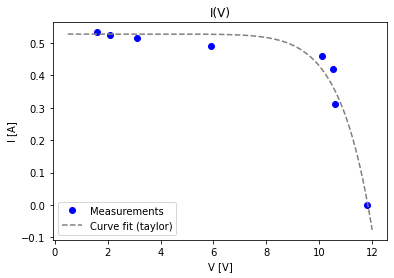

In [19]:
p.add_series('Measurements', V, I, 'o', 'blue')
p.add_series('Curve fit (taylor)', v, I_hat, '--', 'gray')
p.plot(xname='V [V]', yname='I [A]', pname='I(V)')

# Maximum power point

Since $P=IV$ we can quickly get $\hat P_t(V)$.

$ \hat P_t(V) = V \biggr ( I_L - I_S \ e^{zV} \biggr ) = V \biggr ( I_L - I_S \ ( 1 + \sum_{i=1}^{\infty} { \frac{(zV)^i}{i!} } ) \biggr ) $

In [20]:
def P_hat_eq(V, I_L, I_S):
	exp_taylor = 1
	for i in range(1,11): 								
		exp_taylor += (z*V)**i/factorial(i)
	return V*(I_L - I_S * exp_taylor)

Analytically we could find where $\frac{ d \hat P_t }{dV}$ is minimum and solve for $V_{mpp}$. Maybe.

But this isn't a math class - we use computers.

Compute all the power values for a range of voltage values $v$:

In [21]:
v = arange(0.5, 12, .01) 
P_hat = P_hat_eq(v, I_L, I_S)

V_mpp = v[argmax(P_hat)] # armax = index of the maximum value
P_max = max(P_hat)

In [22]:
V_mpp

9.300000000000008

In [23]:
P_max

4.460581407337086

Plot power

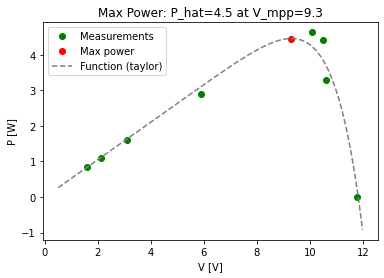

In [24]:
p.add_series('Measurements', V, d.P, 'o', 'green')
p.add_series('Max power', V_mpp, P_max, 'o', 'red')
p.add_series('Function (taylor)', v, P_hat, '--', 'gray')
pname = f'Max Power: P_hat={P_max:.1f} at V_mpp={V_mpp:.1f}'
p.plot(xname='V [V]', yname='P [W]', pname = pname)

Plot current

In [25]:
I_mpp = I_hat[argmax(P_hat)]
I_mpp

0.47963240939108415

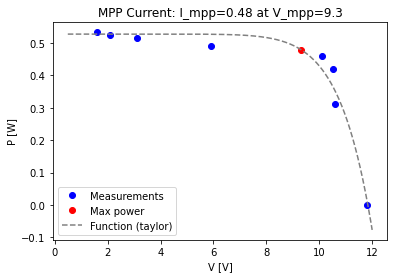

In [26]:
p.add_series('Measurements', V, I, 'o', 'blue')
p.add_series('Max power', V_mpp, I_mpp, 'o', 'red')
p.add_series('Function (taylor)', v, I_hat, '--', 'gray')
pname = f'MPP Current: I_mpp={I_mpp:.2f} at V_mpp={V_mpp:.1f}'
p.plot(xname='V [V]', yname='P [W]', pname = pname)

# Maximum power "tracking"

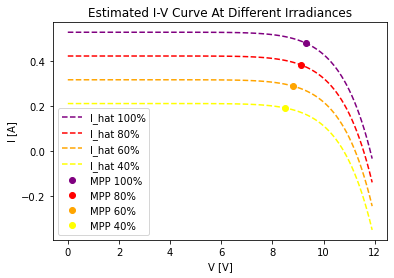

In [40]:
v = arange(0,12,0.1)

I_hat_100 = I_hat_eq(v,1.0*I_L, I_S) 
I_hat_80 =  I_hat_eq(v,0.8*I_L, I_S)
I_hat_60 =  I_hat_eq(v,0.6*I_L, I_S)
I_hat_40 =  I_hat_eq(v,0.4*I_L, I_S)

P_hat_100 = P_hat_eq(v,1.0*I_L, I_S)
P_hat_80 =  P_hat_eq(v,0.8*I_L, I_S)
P_hat_60 =  P_hat_eq(v,0.6*I_L, I_S)
P_hat_40 =  P_hat_eq(v,0.4*I_L, I_S)

i_mpp_100 = argmax(P_hat_100)
i_mpp_80  = argmax(P_hat_80)
i_mpp_60  = argmax(P_hat_60)
i_mpp_40  = argmax(P_hat_40)

p.add_series('I_hat 100%', v, I_hat_100, '--', 'purple')
p.add_series('I_hat 80%', v, I_hat_80,   '--', 'red')
p.add_series('I_hat 60%', v, I_hat_60,   '--', 'orange')
p.add_series('I_hat 40%', v, I_hat_40,   '--', 'yellow')
p.add_series('MPP 100%', v[i_mpp_100], I_hat_100[i_mpp_100], 'o', 'purple')
p.add_series('MPP 80%', v[i_mpp_80], I_hat_80[i_mpp_80], 'o', 'red')
p.add_series('MPP 60%', v[i_mpp_60], I_hat_60[i_mpp_60], 'o', 'orange')
p.add_series('MPP 40%', v[i_mpp_40], I_hat_40[i_mpp_40], 'o', 'yellow')
p.plot(xname='V [V]', yname='I [A]', pname = 'Estimated I-V Curve At Different Irradiances')

Curve fit the MPPs

In [47]:
MPPs = {'v':[v[i_mpp_40], v[i_mpp_60], v[i_mpp_80], v[i_mpp_100]],
        'I_hat':[I_hat_40[i_mpp_100], I_hat_60[i_mpp_60], I_hat_80[i_mpp_100], I_hat_100[i_mpp_100]] }

def MPP_eq(v, a, b):
	return a*v + b

(a,b), _ = curve_fit(MPP_eq, MPPs['v'], MPPs['I_hat'])        

In [48]:
a

0.3807178738570388

In [49]:
b

-3.071476151232828

In [51]:
R = 1/a
R

2.6266168957843683

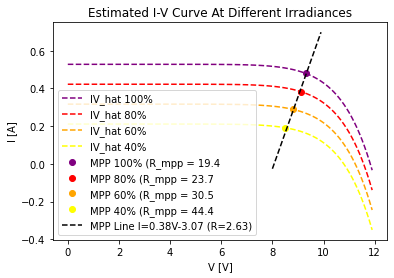

In [62]:
v2 = arange(8,10,0.1)
I_hat_MPPs = MPP_eq(v2, a, b)

p.add_series('IV_hat 100%', v, I_hat_100, '--', 'purple')
p.add_series('IV_hat 80%', v, I_hat_80,   '--', 'red')
p.add_series('IV_hat 60%', v, I_hat_60,   '--', 'orange')
p.add_series('IV_hat 40%', v, I_hat_40,   '--', 'yellow')
p.add_series(f'MPP 100% (R_mpp = {(v[i_mpp_100]/I_hat_100[i_mpp_100]):.1f}', v[i_mpp_100], I_hat_100[i_mpp_100], 'o', 'purple')
p.add_series(f'MPP 80% (R_mpp = {(v[i_mpp_80]/I_hat_80[i_mpp_80]):.1f}',     v[i_mpp_80], I_hat_80[i_mpp_80],    'o', 'red')
p.add_series(f'MPP 60% (R_mpp = {(v[i_mpp_60]/I_hat_60[i_mpp_60]):.1f}',     v[i_mpp_60], I_hat_60[i_mpp_60],    'o', 'orange')
p.add_series(f'MPP 40% (R_mpp = {(v[i_mpp_40]/I_hat_40[i_mpp_40]):.1f}',     v[i_mpp_40], I_hat_40[i_mpp_40],    'o', 'yellow')
p.add_series(f'MPP Line I={a:.2f}V{b:.2f} (R={R:.2f})', v2, I_hat_MPPs, '--', 'black')
p.plot(xname='V [V]', yname='I [A]', pname = 'Estimated I-V Curve At Different Irradiances')

# Outro

Questions

1. Why is the estimated max power $\hat P_{max}$ less than the max actual power $P_{max}$ ? 
   
2. Could this be improved?

3. Is actual measured power as high as you would expect? 

4. What are the possible physical reasons for reduced actual max power?

5. Were we close to standard test conditions?

6. Could there be an inaccuracy due to the "measurement model"?

Repeat steps above but with

1. Taylor expansion out to $i=20$


More

- [PVlib](https://pvlib-python.readthedocs.io/en/v0.9.0/auto_examples/plot_singlediode.html) can do all this
- Different [parameter estimation methods](https://g2voptics.com/photovoltaics-solar-cells/parameter-estimation-methods/)